<a href="https://www.kaggle.com/code/clemwo/bitcoin-transactions-graph-neural-networks?scriptVersionId=194829856" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
!pip install networkx
!pip install torch-geometric
!pip install node2vec

In [292]:
# ---------------------- #
# General Kaggle imports #
# ---------------------- #

import os
for dirname, _, filenames in os.walk('/kaggle/input'): 
    for filename in filenames:
        print(os.path.join(dirname, filename))
import numpy as np
import pandas as pd        


# ------------------ #
# Additional imports #
# ------------------ #

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import torch
import torch_geometric
from torch import Tensor
from torch_geometric.nn import GCNConv, GATConv
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix, 
    ConfusionMatrixDisplay
)


print("Torch version:", torch.__version__)
print("Torch Geometric version:", torch_geometric.__version__)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=mpl.MatplotlibDeprecationWarning)

/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_features.csv
/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_classes.csv
/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv
/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_bitcoin_dataset/elliptic_txs_features.csv
/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_bitcoin_dataset/elliptic_txs_classes.csv
/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv
Torch version: 2.4.0
Torch Geometric version: 2.5.3


In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Nov_22_10:17:15_PST_2023
Cuda compilation tools, release 12.3, V12.3.107
Build cuda_12.3.r12.3/compiler.33567101_0


<img src="https://www.bitcoinsistemi.com/wp-content/uploads/2023/12/bitcoin.jpg" alt="Bitcoin Graph Image" width="800"/>

# 💰Bitcoin Transactions 🔗 Graph Neural Networks 🪙

This notebook tackles [Kaggles Elliptic Bitcoin Transaction Dataset](https://www.kaggle.com/datasets/ellipticco/elliptic-data-set/data) which maps Bitcoin transactions to real entities. In the description the objective for this dataset is described as:
> classifying the illicit and licit nodes in the graph.

[Wikipedia describes Bitcoin](https://en.wikipedia.org/wiki/Bitcoin) as the first decentralized cryptocurrency. It also states that nodes in the Bitcoin network verify transactions through cryptography and record them in a public distributed ledger, called _blockchain_. The dataset we are going to work on in this notebook is an anonymized transaction graph collexted from such Bitcoin blockchain. Kaggles Data Card describes the dataset as having the following content: 

__Dataset Content__
- _Node_: represents a transaction. 
    - Each has 166 features
    - Labeled as ✅ _licit_, ❌ _illicit_ or 🤷 _unknown_
- _Edge_: represents a flow of Bitcoins between transaction `A` and transaction `B` 

Before we start, here are a couple concepts you should know for better understanding of the following code: 

| Concept | Math Notation | Description | More Information | 
| ------- | ------------- | ----------- | ---------------- |
| Graph | $G$ | Defined as pair $G=(V,E)$, where $V$ is a set of vertices and $E$ is a set of edges which are unordered pairs ${v_1, v_2}$ of vertices. | [Wikipedia: Graph (discrete mathematics)](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)) | 
| Degree | $deg$ | Number of edges that are incident to a vertex. | [Wikipedia: Degree (graph theory)](https://en.wikipedia.org/wiki/Degree_(graph_theory)) | 
| Component | | Connected subgraph that is not part of any larger connected subgraph. | [Wikipedia: Component (graph theory](https://en.wikipedia.org/wiki/Component_(graph_theory)) | 

🚨 In the following notebook we will always call the graph $G$, the set of nodes $V$ and the set of edges $E$. 🚨

# Global Settings

In [4]:
RANDOM_STATE = 42

# Overview

Let's start by getting an overview of the datasets.

In [86]:
elliptic_txs_features = pd.read_csv('/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None)
elliptic_txs_classes = pd.read_csv('/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_classes.csv')
elliptic_txs_edgelist = pd.read_csv('/kaggle/input/elliptic-data-set/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv')

elliptic_txs_features.columns = ['txId'] + [f'V{i}' for i in range(1, 167)]

print(f"""Shapes
{4*' '}Features : {elliptic_txs_features.shape[0]:8,} (rows)  {elliptic_txs_features.shape[1]:4,} (cols)
{4*' '}Classes  : {elliptic_txs_classes.shape[0]:8,} (rows)  {elliptic_txs_classes.shape[1]:4,} (cols)
{4*' '}Edgelist : {elliptic_txs_edgelist.shape[0]:8,} (rows)  {elliptic_txs_edgelist.shape[1]:4,} (cols)
""")

Shapes
    Features :  203,769 (rows)   167 (cols)
    Classes  :  203,769 (rows)     2 (cols)
    Edgelist :  234,355 (rows)     2 (cols)



__Nodes & Edges__

- $|V| = 203,768$ (number of nodes in $G$)
- $|E| = 234,355$ (number of edges in $G$)

In [87]:
elliptic_txs_features.head(3)  # Dataset containing the node features.

,txId,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792


In [88]:
elliptic_txs_classes.head(3)  # Dataset containing the classes of the node.

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown


In [89]:
elliptic_txs_edgelist.head(3)  # Dataset containing the edges.

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870


Let's get an overview on the distribution of the `class`es. 

In [90]:
elliptic_txs_classes['class_mapped'] = elliptic_txs_classes['class'].replace({'1': 'illicit', '2': 'licit'})

percentage_distribution = round(100 * elliptic_txs_classes['class_mapped'].value_counts(normalize=True), 2)
class_counts = elliptic_txs_classes['class_mapped'].value_counts()

emoji_mapping = {'licit': '✅', 'illicit': '❌', 'unknown': '🤷'}
elliptic_txs_classes['emoji'] = elliptic_txs_classes['class_mapped'].map(emoji_mapping)

classes_df = pd.DataFrame({
    'Class Mapped': elliptic_txs_classes['class_mapped'].unique(),
    'Class Raw': elliptic_txs_classes['class'].unique(),    
    'Counts': class_counts.values,
    'Percentage': percentage_distribution.values,
    'Emoji': [emoji_mapping[class_label] for class_label in elliptic_txs_classes['class_mapped'].unique()]
})
classes_df

,Class Mapped,Class Raw,Counts,Percentage,Emoji
0,unknown,unknown,157205,77.15,🤷
1,licit,2,42019,20.62,✅
2,illicit,1,4545,2.23,❌


- 77.15% of all classes are `unknown`
- 20.62% of all classes are `licit` (2)
- 2.23% of all classes are `illicit` (1)

In [10]:
# Sampling for easier analysis...for now.
classes_sampled = elliptic_txs_classes.groupby('class_mapped').sample(frac=0.05, random_state=RANDOM_STATE)
txIds_sampled = classes_sampled['txId']

# Filter elliptic_txs_edgelist based on the sampled txIds
edgelist_sampled = elliptic_txs_edgelist[
    elliptic_txs_edgelist['txId1'].isin(txIds_sampled) | elliptic_txs_edgelist['txId2'].isin(txIds_sampled)
]

# Filter elliptic_txs_features based on the sampled txIds
features_sampled = elliptic_txs_features[elliptic_txs_features['txId'].isin(txIds_sampled)]

print(f"Sampled Classes:\n{classes_sampled['class_mapped'].value_counts()}\n")
print(f"Sampled Edgelist: {edgelist_sampled.shape[0]:,}")
print(f"Sampled Features: {features_sampled.shape[0]:,}")

Sampled Classes:
class_mapped
unknown    7860
licit      2101
illicit     227
Name: count, dtype: int64

Sampled Edgelist: 23,051
Sampled Features: 10,188


# Exploratory Data Analysis (EDA) 

## Basic Statistics

Number of nodes: 10,188
Number of edges: 23,051


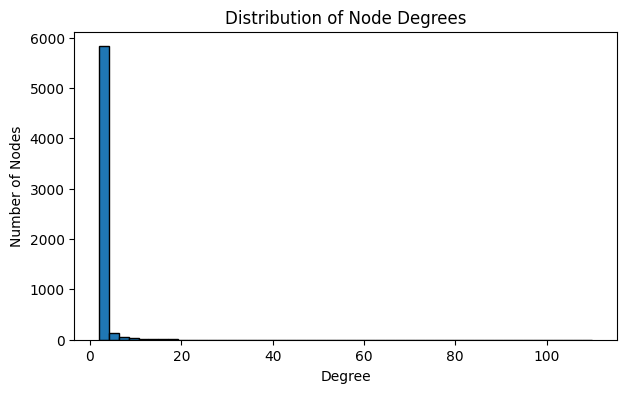

In [11]:
# Number of nodes and edges
num_nodes = features_sampled.shape[0]
num_edges = edgelist_sampled.shape[0]

print(f"Number of nodes: {num_nodes:,}")
print(f"Number of edges: {num_edges:,}")

# Distribution of node degrees
plt.figure(figsize=(7, 4))

node_degrees = edgelist_sampled['txId1'].value_counts() + edgelist_sampled['txId2'].value_counts()
node_degrees.hist(bins=50, edgecolor='black')
plt.title('Distribution of Node Degrees')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.grid(False)
plt.show()

## Graph Connectivity

In [12]:
# Create graph from the edgelist.
G = nx.from_pandas_edgelist(edgelist_sampled, 'txId1', 'txId2')

Number of connected components: 7297
Giant component - Number of nodes: 400
Giant component - Number of edges: 431


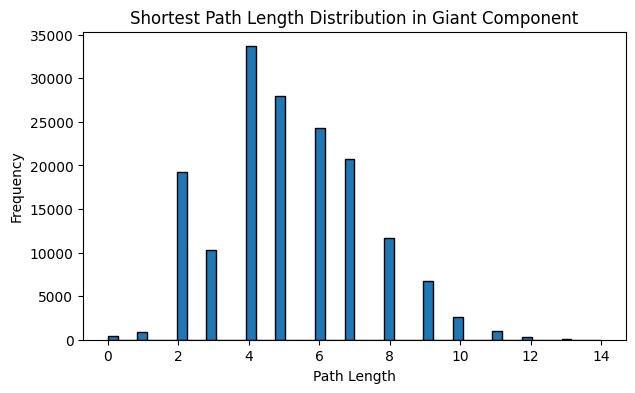

In [13]:
# --- Connected components ---
num_connected_components = nx.number_connected_components(G)
print(f"Number of connected components: {num_connected_components}")

# --- Giant component analysis ---
giant_component = max(nx.connected_components(G), key=len)
G_giant = G.subgraph(giant_component)

print(f"Giant component - Number of nodes: {G_giant.number_of_nodes():,}")
print(f"Giant component - Number of edges: {G_giant.number_of_edges():,}")


# --------------------------------------------------------- #
# Shortest paths length distribution in the giant component #
# --------------------------------------------------------- #
path_lengths = dict(nx.shortest_path_length(G_giant))
path_lengths_values = [length for target_lengths in path_lengths.values() for length in target_lengths.values()]

plt.figure(figsize=(7, 4))
plt.hist(path_lengths_values, bins=50, edgecolor='black')
plt.title('Shortest Path Length Distribution in Giant Component')
plt.xlabel('Path Length')
plt.ylabel('Frequency')
plt.show()

## Node Centrality Measures

In this section we are going to investigate node centrality measures. Such measures are used in graph theory to identify the most important or influential nodes within a network. We will focus on the following three centrality measures: 

___🔢 Degree Centrality___

**Definition:**
Degree centrality measures the number of direct connections a node has in a network. It is defined as the number of edges connected to a node.

**Mathematical Function:**
$$
\begin{aligned}
& C_D(v) = \frac{\text{deg}(v)}{N - 1} \\ 
& \text{Where:} \\
& \qquad \text{deg}(v) \; \text{is the degree of node} \; (v) \; \text{(i.e., the number of edges connected to the node).} \\
& \qquad N \; \text{is the total number of nodes in the network.}
\end{aligned}
$$

**Interpretation:**
A node with a high degree centrality is highly connected and may play a crucial role in the network by having direct interactions with many other nodes.

___🔀 Betweenness Centrality___

**Definition:**
Betweenness centrality measures the extent to which a node lies on the shortest paths between other nodes in the network.

**Mathematical Function:**
$$
\begin{aligned}
& C_B(v) = \sum_{s \neq v \neq t} \frac{\sigma_{st}(v)}{\sigma_{st}} \\
& \text{Where:} \\
& \qquad \sigma_{st} \; \text{is the total number of shortest paths between nodes} \; (s) \; \text{and} \; (t). \\
& \qquad \sigma_{st}(v) \; \text{is the number of those paths that pass through node} \; (v).
\end{aligned}
$$

**Interpretation:**
A node with high betweenness centrality has significant control over the flow of information or resources in the network because it connects different parts of the network. It often indicates a node that is critical for communication.

___🌐 Closeness Centrality___

**Definition:**
Closeness centrality measures how close a node is to all other nodes in the network. It is the reciprocal of the sum of the shortest path distances from the node to all other nodes in the network.

**Mathematical Function:**
$$
\begin{aligned}
& C_C(v) = \frac{N-1}{\sum_{t \neq v} d(v, t)} \\
& \text{Where:} \\ 
& \qquad d(v, t) \; \text{is the shortest path distance between node} \; (v) \; \text{and node} \; (t). \\
& \qquad N \; \text{is the total number of nodes in the network.}
\end{aligned}
$$

**Interpretation:**
A node with high closeness centrality can quickly interact with all other nodes and can be an effective spreader of information or influence throughout the network.

---


Top 10 nodes by degree centrality:
        Node  Degree Centrality
0   22837965           0.275689
1   22837835           0.192982
2  279199578           0.030075
3    3807285           0.027569
4  279187194           0.027569
5   22837973           0.022556
6   90716926           0.022556
7    8128388           0.022556
8   22837808           0.020050
9   22838007           0.020050


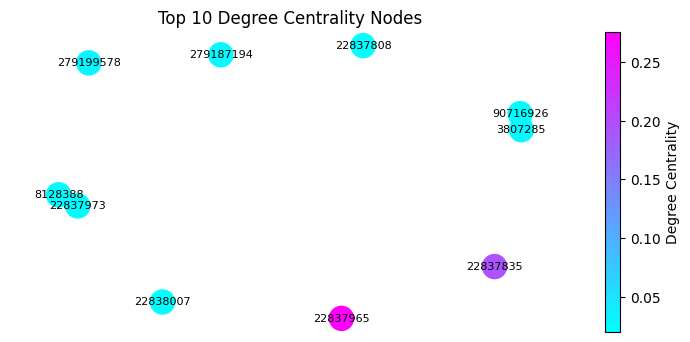

In [14]:
# Degree centrality.
degree_centrality = nx.degree_centrality(G_giant)
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_degree_centrality = pd.DataFrame(top_degree_centrality, columns=['Node', 'Degree Centrality'])

print("Top 10 nodes by degree centrality:")
print("==================================")
print(df_top_degree_centrality)

top_nodes_by_ = df_top_degree_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_)
node_color = [degree_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool

# -------- #
# Plotting #
# -------- #
plt.figure(figsize=(7, 3))

nx.draw(subgraph, with_labels=True, node_size=300, edge_color='gray', font_size=8, 
        node_color=node_color_normalized, cmap=cmap)
plt.title('Top 10 Degree Centrality Nodes')
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label='Degree Centrality')
plt.show()

Top 10 nodes by betweenness centrality:
        Node  Betweenness Centrality
0   22837835                0.553959
1   22837965                0.491607
2   90716926                0.166458
3   22837784                0.165590
4  279187194                0.164591
5    3807285                0.144993
6    3097782                0.113509
7    8128388                0.103709
8    1435388                0.092219
9   21296808                0.086872


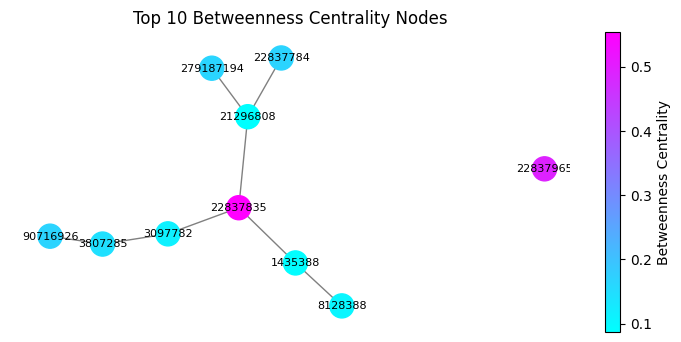

In [15]:
# Betweenness centrality.
betweenness_centrality = nx.betweenness_centrality(G_giant)
top_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_betweenness_centrality = pd.DataFrame(top_betweenness_centrality, columns=['Node', 'Betweenness Centrality'])

print("Top 10 nodes by betweenness centrality:")
print("=======================================")
print(df_top_betweenness_centrality)

top_nodes_by_ = df_top_betweenness_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_)
node_color = [betweenness_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool

# -------- #
# Plotting #
# -------- #
plt.figure(figsize=(7, 3))

nx.draw(subgraph, with_labels=True, node_size=300, edge_color='gray', font_size=8, 
        node_color=node_color_normalized, cmap=cmap)
plt.title('Top 10 Betweenness Centrality Nodes')
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label='Betweenness Centrality')
plt.show()

Top 10 nodes by closeness centrality:
        Node  Closeness Centrality
0   22837835              0.317928
1   22837965              0.293814
2    2203811              0.290605
3    1805107              0.285817
4   11447640              0.285817
5    2205152              0.285817
6    1367537              0.285817
7    1437191              0.285817
8   21296808              0.274038
9  279187194              0.271613


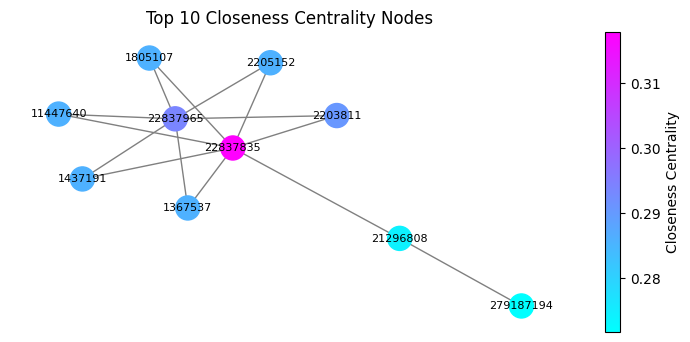

In [16]:
# Closeness centrality.
closeness_centrality = nx.closeness_centrality(G_giant)
top_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
df_top_closeness_centrality = pd.DataFrame(top_closeness_centrality, columns=['Node', 'Closeness Centrality'])

print("Top 10 nodes by closeness centrality:")
print("=====================================")
print(df_top_closeness_centrality)

top_nodes_by_closeness = df_top_closeness_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_closeness)
node_color = [closeness_centrality[node] for node in subgraph.nodes()]
norm = mpl.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
node_color_normalized = [norm(value) for value in node_color]
cmap = plt.cm.cool

# -------- #
# Plotting #
# -------- #
plt.figure(figsize=(7, 3))

nx.draw(subgraph, with_labels=True, node_size=300, edge_color='gray', font_size=8, 
        node_color=node_color_normalized, cmap=cmap)
plt.title('Top 10 Closeness Centrality Nodes')
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label='Closeness Centrality')
plt.show()

## Graph Visualization

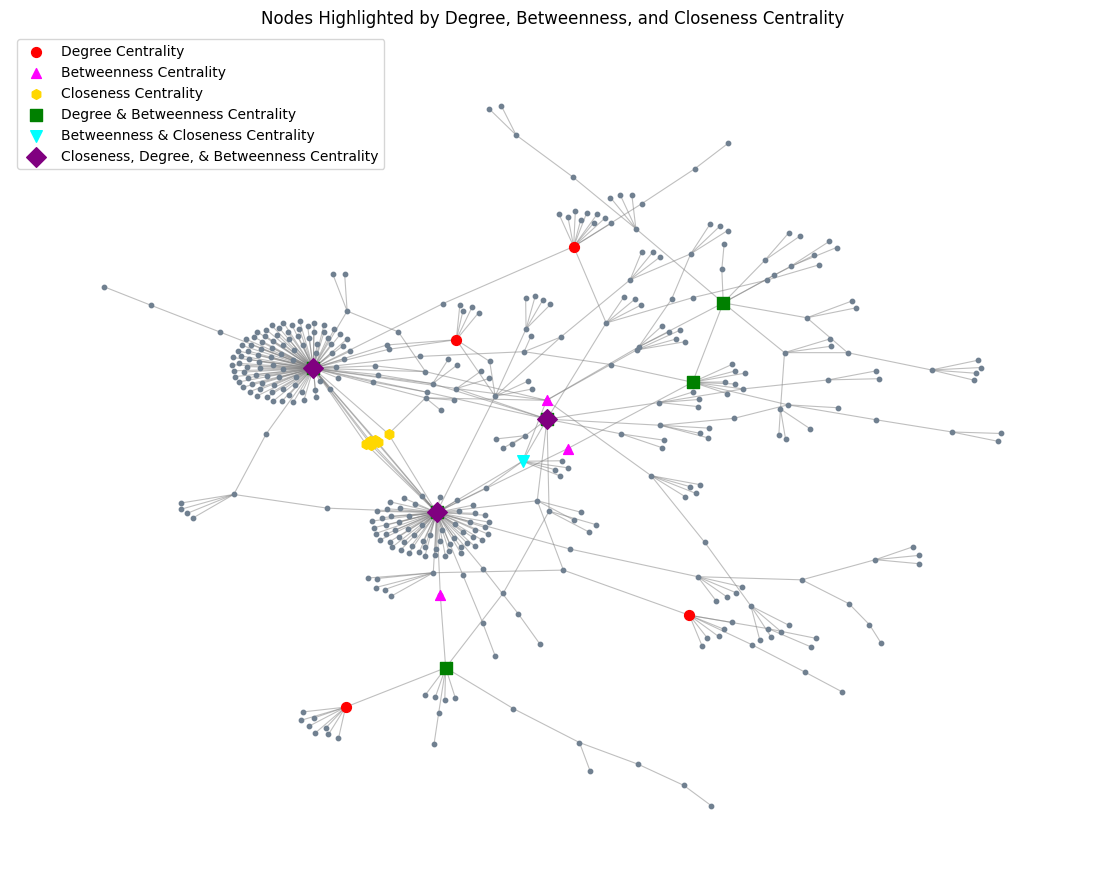

In [17]:
# --------- #
# Preparing #
# --------- #

# Identify nodes that are top in each centrality measure and their combinations.
top_nodes_degree = set([node for node, _ in top_degree_centrality])
top_nodes_betweenness = set([node for node, _ in top_betweenness_centrality])
top_nodes_closeness = set([node for node, _ in top_closeness_centrality])

top_nodes_both = top_nodes_degree.intersection(top_nodes_betweenness)
top_nodes_closeness_and_degree = top_nodes_closeness.intersection(top_nodes_degree)
top_nodes_closeness_and_betweenness = top_nodes_closeness.intersection(top_nodes_betweenness)
top_nodes_all_three = top_nodes_closeness.intersection(top_nodes_degree).intersection(top_nodes_betweenness)

# Assign colors and shapes based on centrality measures.
node_color = []
node_shape = []

for node in G_giant.nodes():
    if node in top_nodes_all_three:
        node_color.append('purple')
        node_shape.append('D')
    elif node in top_nodes_closeness_and_degree and node in top_nodes_closeness_and_betweenness:
        node_color.append('blue')
        node_shape.append('p')
    elif node in top_nodes_both:
        node_color.append('green')
        node_shape.append('s')
    elif node in top_nodes_closeness_and_degree:
        node_color.append('orange')
        node_shape.append('h')
    elif node in top_nodes_closeness_and_betweenness:
        node_color.append('cyan')
        node_shape.append('v')
    elif node in top_nodes_degree:
        node_color.append('red')
        node_shape.append('o')
    elif node in top_nodes_betweenness:
        node_color.append('magenta')
        node_shape.append('^')
    elif node in top_nodes_closeness:
        node_color.append('yellow')
        node_shape.append('h')
    else:
        node_color.append('slategrey')
        node_shape.append('o')

# -------- #
# Plotting #
# -------- #

plt.figure(figsize=(14, 11))

pos = nx.spring_layout(G_giant)
# Draw all nodes first.
nx.draw_networkx_nodes(G_giant, pos, node_color='slategrey', node_size=10)

# Draw nodes with specific centrality measures.
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_degree - top_nodes_both - top_nodes_closeness_and_degree), 
                       node_color='red', node_size=50, node_shape='o', 
                       label='Degree Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_betweenness - top_nodes_both - top_nodes_closeness_and_betweenness), 
                       node_color='magenta', node_size=50, node_shape='^', 
                       label='Betweenness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_closeness - top_nodes_closeness_and_degree - top_nodes_closeness_and_betweenness), 
                       node_color='gold', node_size=50, node_shape='h', 
                       label='Closeness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_both), 
                       node_color='green', node_size=80, node_shape='s', 
                       label='Degree & Betweenness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_closeness_and_degree - top_nodes_all_three), 
                       node_color='orange', node_size=70, node_shape='h', 
                       label='Degree & Closeness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_closeness_and_betweenness - top_nodes_all_three), 
                       node_color='cyan', node_size=70, node_shape='v', 
                       label='Betweenness & Closeness Centrality')
nx.draw_networkx_nodes(G_giant, pos, nodelist=list(top_nodes_all_three), 
                       node_color='purple', node_size=100, node_shape='D', 
                       label='Closeness, Degree, & Betweenness Centrality')

# Draw edges.
nx.draw_networkx_edges(G_giant, pos, width=0.8, edge_color='gray', alpha=0.5)

plt.axis('off')
plt.title('Nodes Highlighted by Degree, Betweenness, and Closeness Centrality')
plt.legend(scatterpoints=1)
plt.show()

## Class-specific Analysis

In [18]:
# Class-based subgraphs.
illicit_nodes = classes_sampled[classes_sampled['class_mapped'] == 'illicit']['txId']
licit_nodes = classes_sampled[classes_sampled['class_mapped'] == 'licit']['txId']

G_illicit = G.subgraph(illicit_nodes)
G_licit = G.subgraph(licit_nodes)

In [19]:
classes_df

,Class Mapped,Class Raw,Counts,Percentage,Emoji
0,unknown,unknown,157205,77.15,🤷
1,licit,2,42019,20.62,✅
2,illicit,1,4545,2.23,❌


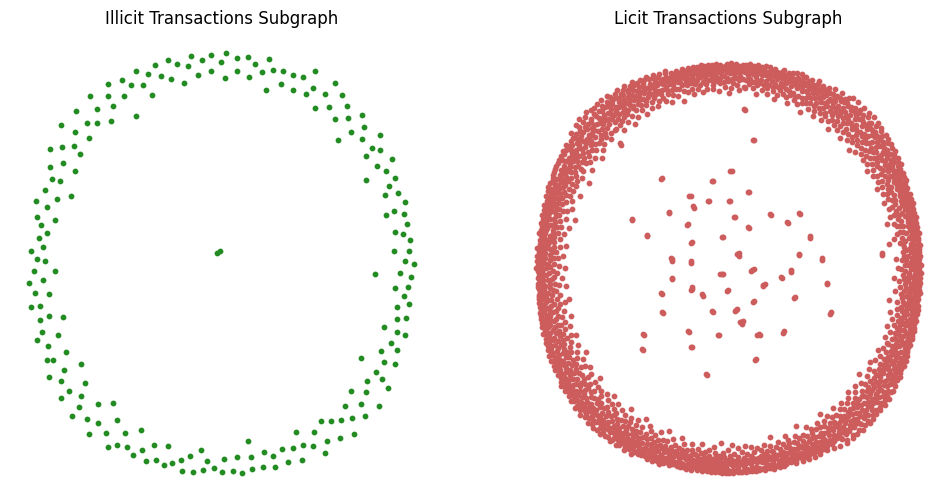

In [20]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
nx.draw(G_illicit, with_labels=False, node_size=10, node_color='forestgreen', edge_color='black')
plt.title('Illicit Transactions Subgraph')

plt.subplot(1, 2, 2)
nx.draw(G_licit, with_labels=False, node_size=10, node_color='indianred', edge_color='black')
plt.title('Licit Transactions Subgraph')

plt.show()

# Community Detection

The goal of community detection is to identify clusters or communities within the graph where nodes are more densely connected internally than with the rest of the graph.

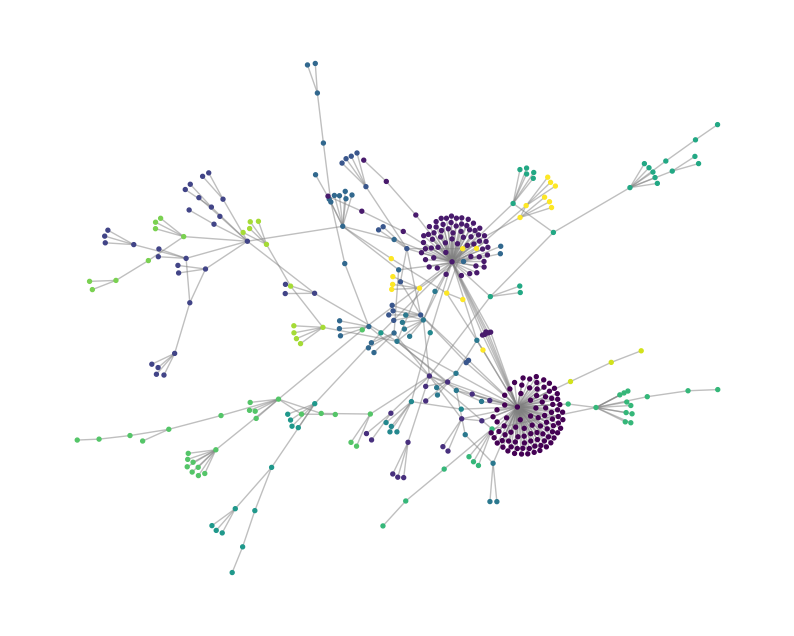

In [30]:
import community as community_louvain

# Compute best partition.
partition = community_louvain.best_partition(G_giant)

# Draw graph.
plt.figure(figsize=(10, 8))

pos = nx.spring_layout(G_giant)
cmap = plt.get_cmap('viridis')
nx.draw_networkx_nodes(G_giant, pos, node_color=list(partition.values()), node_size=8, cmap=cmap)
nx.draw_networkx_edges(G_giant, pos, alpha=0.5, edge_color='grey')
plt.axis('off')

plt.show()

# 🧠 Graph Neural Networks 

Graph Neural Networks (GNNs) are a deep learning technique specifically designed for graph data, useful for tasks like node classification, graph classification, or link prediction. In our case, for now, we will perform ___node prediction___.

## 🛠️ Pre-Processing

In [163]:
num_edges = elliptic_txs_edgelist.shape[0]
num_nodes = elliptic_txs_features.shape[0]

print(f'Number of edges in the graph: {num_edges:8,}')
print(f'Number of nodes in the graph: {num_nodes:8,}')

Number of edges in the graph:  234,355
Number of nodes in the graph:  203,769


In [164]:
# --------------------------------------------------------- #
# Create mapping with txId as key and actual index as value #
# --------------------------------------------------------- #

tx_id_mapping = {tx_id: idx for idx, tx_id in enumerate(elliptic_txs_features['txId'])}

edges_with_features = elliptic_txs_edgelist[elliptic_txs_edgelist['txId1'].isin(list(tx_id_mapping.keys()))\
                                          & elliptic_txs_edgelist['txId2'].isin(list(tx_id_mapping.keys()))]

edges_with_features['Id1'] = edges_with_features['txId1'].map(tx_id_mapping)
edges_with_features['Id2'] = edges_with_features['txId2'].map(tx_id_mapping)

edges_with_features

,txId1,txId2,Id1,Id2
0,230425980,5530458,0,1
1,232022460,232438397,2,3
2,230460314,230459870,4,5
3,230333930,230595899,6,7
4,232013274,232029206,8,9
...,...,...,...,...
234350,158365409,157930723,203602,201430
234351,188708874,188708879,203603,203099
234352,157659064,157659046,201921,202042
234353,87414554,106877725,201480,201368


In [107]:
edge_index = torch.tensor(edges_with_features[['Id1', 'Id2']].values.T, dtype=torch.long)
edge_index

tensor([[     0,      2,      4,  ..., 201921, 201480, 201954],
        [     1,      3,      5,  ..., 202042, 201368, 201756]])

In [108]:
# ------------------------------------- #
# Save node features in suitable format #
# ------------------------------------- #

node_features = torch.tensor(elliptic_txs_features.drop(columns=['txId']).values, 
                             dtype=torch.float)
print(node_features.shape)
node_features

torch.Size([203769, 166])


tensor([[ 1.0000e+00, -1.7147e-01, -1.8467e-01,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01],
        [ 1.0000e+00, -1.7148e-01, -1.8467e-01,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01],
        [ 1.0000e+00, -1.7211e-01, -1.8467e-01,  ..., -1.8367e-01,
         -1.2061e-01, -1.1979e-01],
        ...,
        [ 4.9000e+01, -1.7201e-01, -7.8182e-02,  ..., -9.7524e-02,
         -1.2061e-01, -1.1979e-01],
        [ 4.9000e+01, -1.7284e-01, -1.7662e-01,  ..., -1.4060e-01,
          1.5197e+00,  1.5214e+00],
        [ 4.9000e+01, -1.2037e-02, -1.3228e-01,  ..., -1.4060e-01,
          1.5197e+00,  1.5214e+00]])

- 1st dimension tells us about the `# of nodes`
- 2nd dimension tells us about the `# of node features`

In [109]:
# ------------------------ #
# Labelencode target class #
# ------------------------ #

le = LabelEncoder()
class_labels = le.fit_transform(elliptic_txs_classes['class'])
node_labels = torch.tensor(class_labels, dtype=torch.long)

print(class_labels)
print(node_labels)

[2 2 2 ... 0 2 2]
tensor([2, 2, 2,  ..., 0, 2, 2])


In [110]:
# ------------------------------------ #
# Create pytorch geometric Data object #
# ------------------------------------ #

data = Data(x=node_features, 
            edge_index=edge_index, 
            y=node_labels)

In [169]:
# ------------------------------------------------ #
# Define size for Training, Validation and Testing #
# ------------------------------------------------ #

num_nodes    = data.num_nodes
permutations = torch.randperm(num_nodes)  # To randomize the splits
train_size   = int(0.8 * num_nodes)
val_size     = int(0.1 * num_nodes)
test_size    = num_nodes - train_size - val_size

total = np.sum([train_size, val_size, test_size])

print(f"""Number of observations per split
    Training   : {train_size:10,} ({100*train_size/total:0.2f} %)
    Validation : {val_size:10,} ({100*val_size/total:0.2f} %)
    Testing    : {test_size:10,} ({100*test_size/total:0.2f} %)
""")

Number of observations per split
    Training   :    163,015 (80.00 %)
    Validation :     20,376 (10.00 %)
    Testing    :     20,378 (10.00 %)



In [112]:
# ----------------------------------------------- #
# Create mask for the indices of Train, Val, Test #
# ----------------------------------------------- #

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

data.train_mask[permutations[:train_size]] = True
data.val_mask[permutations[train_size:train_size + val_size]] = True
data.test_mask[permutations[train_size + val_size:]] = True

data.train_mask

tensor([ True,  True, False,  ...,  True,  True,  True])

## 1️⃣ - GCN

In [113]:
# -------------- #
# Define the GCN #
# -------------- #

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


# ---------- #
# Initialize #
# ---------- #

model = GCN(num_node_features=data.num_features, num_classes=len(le.classes_))
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=0.01, 
                             weight_decay=0.0005)
criterion = torch.nn.CrossEntropyLoss()  # Since we have a multiclass classification problem.

In [191]:
# ------------------------------------------- #
# Training, Evaluation and prediction methods #
# ------------------------------------------- #

def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()


def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        
        correct = (pred[mask] == data.y[mask]).sum().item()
        accuracy = correct / mask.sum().item()

        y_true = data.y[mask].cpu().numpy()
        y_pred = pred[mask].cpu().numpy()

        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }

    return metrics

def predict(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
    return pred

In [192]:
train_losses = []
train_accuracies = []
train_precisions = []
train_recalls = []
train_f1_scores = []

val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []

# ----- #
# Train #
# ----- #

NUM_EPOCHS = 100

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], 
                     data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    # --- Calculate training metrics ---
    pred_train = out[data.train_mask].argmax(dim=1)
    correct_train = (pred_train == data.y[data.train_mask]).sum()
    train_acc = int(correct_train) / int(data.train_mask.sum())
    train_accuracies.append(train_acc)
    
    y_true_train = data.y[data.train_mask].cpu().numpy()
    y_pred_train = pred_train.cpu().numpy()
    
    train_prec = precision_score(y_true_train, y_pred_train, average='weighted', zero_division=0)
    train_rec = recall_score(y_true_train, y_pred_train, average='weighted', zero_division=0)
    train_f1 = f1_score(y_true_train, y_pred_train, average='weighted', zero_division=0)
    
    train_precisions.append(train_prec)
    train_recalls.append(train_rec)
    train_f1_scores.append(train_f1)
    train_losses.append(loss.item())
    
    # --- Validate and calculate validation metrics ---
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred_val = out[data.val_mask].argmax(dim=1)
        correct_val = (pred_val == data.y[data.val_mask]).sum()
        val_acc = int(correct_val) / int(data.val_mask.sum())
        val_accuracies.append(val_acc)

        y_true_val = data.y[data.val_mask].cpu().numpy()
        y_pred_val = pred_val.cpu().numpy()

        val_prec = precision_score(y_true_val, y_pred_val, average='weighted', zero_division=0)
        val_rec = recall_score(y_true_val, y_pred_val, average='weighted', zero_division=0)
        val_f1 = f1_score(y_true_val, y_pred_val, average='weighted', zero_division=0)

        val_precisions.append(val_prec)
        val_recalls.append(val_rec)
        val_f1_scores.append(val_f1)
        
    if epoch % 10 == 0:        
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Train - Acc: {train_acc:.4f} - Prec: {train_prec:.4f} - Rec: {train_rec:.4f} - F1: {train_f1:.4f}')
        print(f'                         Val   - Acc: {val_acc:.4f} - Prec: {val_prec:.4f} - Rec: {val_rec:.4f} - F1: {val_f1:.4f}')        

Epoch 010, Loss: 0.3605, Train - Acc: 0.8656 - Prec: 0.8564 - Rec: 0.8656 - F1: 0.8519
                         Val   - Acc: 0.8570 - Prec: 0.8461 - Rec: 0.8570 - F1: 0.8418
Epoch 020, Loss: 0.3633, Train - Acc: 0.8663 - Prec: 0.8567 - Rec: 0.8663 - F1: 0.8541
                         Val   - Acc: 0.8565 - Prec: 0.8449 - Rec: 0.8565 - F1: 0.8410
Epoch 030, Loss: 0.3621, Train - Acc: 0.8665 - Prec: 0.8568 - Rec: 0.8665 - F1: 0.8537
                         Val   - Acc: 0.8559 - Prec: 0.8441 - Rec: 0.8559 - F1: 0.8397
Epoch 040, Loss: 0.3623, Train - Acc: 0.8648 - Prec: 0.8554 - Rec: 0.8648 - F1: 0.8496
                         Val   - Acc: 0.8585 - Prec: 0.8482 - Rec: 0.8585 - F1: 0.8451
Epoch 050, Loss: 0.3609, Train - Acc: 0.8665 - Prec: 0.8571 - Rec: 0.8665 - F1: 0.8537
                         Val   - Acc: 0.8576 - Prec: 0.8473 - Rec: 0.8576 - F1: 0.8425
Epoch 060, Loss: 0.3606, Train - Acc: 0.8661 - Prec: 0.8572 - Rec: 0.8661 - F1: 0.8520
                         Val   - Acc: 0.857

In [193]:
# -------- #
# Evaluate #
# -------- #

model.eval()
with torch.no_grad():
    
    test_metrics = evaluate(model, data, data.test_mask)
    test_acc = test_metrics.get('accuracy')
    test_prec = test_metrics.get('precision')
    test_rec = test_metrics.get('recall')
    test_f1 = test_metrics.get('f1_score')

    print(f'Test Acc: {test_acc:.4f} - Prec: {test_prec:.4f} - Rec: {test_rec:.4f} - F1: {test_f1:.4f}')

Test Acc: 0.8611 - Prec: 0.8528 - Rec: 0.8611 - F1: 0.8455


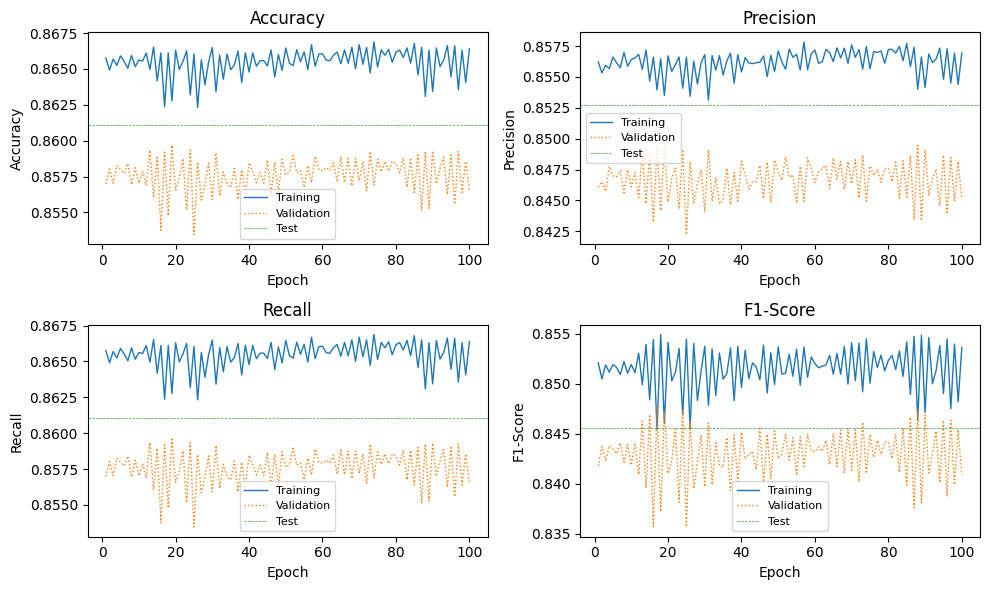

In [213]:
plt.figure(figsize=(10, 6))

# --- Accuracy ----
plt.subplot(2, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, color='C0', linewidth=1.0, label='Training')
plt.plot(range(1, NUM_EPOCHS + 1), val_accuracies, color='C1', linewidth=1.0, label='Validation', linestyle=':')
plt.axhline(y=test_acc, color='C2', linewidth=0.5, linestyle='--', label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(fontsize=8)
plt.title('Accuracy')

# --- Precision ---
plt.subplot(2, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), train_precisions, color='C0', linewidth=1.0, label='Training')
plt.plot(range(1, NUM_EPOCHS + 1), val_precisions, color='C1', linewidth=1.0, label='Validation', linestyle=':')
plt.axhline(y=test_prec, color='C2', linewidth=0.5, linestyle='--', label='Test')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(fontsize=8)
plt.title('Precision')

# --- Recall ---
plt.subplot(2, 2, 3)
plt.plot(range(1, NUM_EPOCHS + 1), train_recalls, color='C0', linewidth=1.0, label='Training')
plt.plot(range(1, NUM_EPOCHS + 1), val_recalls, color='C1', linewidth=1.0, label='Validation', linestyle=':')
plt.axhline(y=test_rec, color='C2', linewidth=0.5, linestyle='--', label='Test')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(fontsize=8)
plt.title('Recall')

# --- F1-Score ---
plt.subplot(2, 2, 4)
plt.plot(range(1, NUM_EPOCHS + 1), train_f1_scores, linewidth=1.0, color='C0', label='Training')
plt.plot(range(1, NUM_EPOCHS + 1), val_f1_scores, linewidth=1.0, color='C1', label='Validation', linestyle=':')
plt.axhline(y=test_f1, color='C2', linewidth=0.5, linestyle='--', label='Test')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend(fontsize=8)
plt.title('F1-Score')

plt.tight_layout()
plt.show()

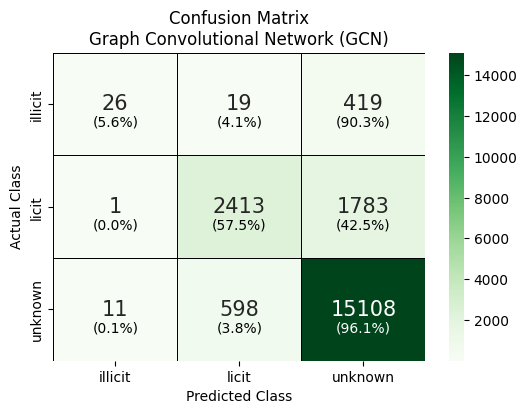

In [291]:
test_pred = predict(model, data)[data.test_mask]

# Map the actual name to the raw class name.
mapping = dict(zip(classes_df['Class Raw'], classes_df['Class Mapped']))
mapped_classes = np.array([mapping[class_value] for class_value in le.classes_])

# --- Confusion matrix ---
cm = confusion_matrix(data.y[data.test_mask].cpu(), test_pred.cpu())

fig, ax = plt.subplots(figsize=(6, 4))

sns.heatmap(cm, annot=True, fmt='g', cmap=plt.cm.Greens, 
            annot_kws={'size': 15}, 
            xticklabels=mapped_classes,
            yticklabels=mapped_classes, 
            linecolor='black', linewidth=0.5,
            ax=ax)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

# Annotate each cell with the percentage of that row.
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percentage = cm_normalized[i, j] * 100
        text = f'\n({percentage:.1f}%)'
        color = 'white' if percentage > 95 else 'black'
        ax.text(j + 0.5, i + 0.6, text,
                ha='center', va='center', fontsize=10, color=color)

plt.title('Confusion Matrix\nGraph Convolutional Network (GCN)')
plt.show()

- The model is very good at predicting `unknown` class. Simply because it's the majority of the dataset.
- The GCN is also decent at predicting if a node is `licit` or not. However, it predicted 42% of all `licit` nodes as being `unknown`. 
- The model is very bad at predicting `illicit` nodes. It only classified 5% of all `illicit` nodes correctly. Thus, it's recall is 5%. 

## 2️⃣ - GAT 

In [293]:
# -------------- #
# Define the GAT #
# -------------- #

class GAT(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, num_heads=8):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_node_features, 8, heads=num_heads, dropout=0.6)
        self.conv2 = GATConv(8 * num_heads, num_classes, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# ---------- #
# Initialize #
# ---------- #

model = GAT(num_node_features=data.num_features, num_classes=len(le.classes_))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0005)
criterion = torch.nn.CrossEntropyLoss()  # Since we have a multiclass classification problem.


In [296]:
# ------------------------------------------- #
# Training, Evaluation and prediction methods #
# ------------------------------------------- #

def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()


def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        
        correct = (pred[mask] == data.y[mask]).sum().item()
        accuracy = correct / mask.sum().item()

        y_true = data.y[mask].cpu().numpy()
        y_pred = pred[mask].cpu().numpy()

        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }

    return metrics

def predict(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
    return pred

In [301]:
import torch

# Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model and data to the GPU
model = GAT(num_node_features=data.num_features, num_classes=len(le.classes_)).to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0005)
criterion = torch.nn.CrossEntropyLoss()  # Since we have a multiclass classification problem.

# Initialize lists to store metrics
train_losses = []
train_accuracies = []
train_precisions = []
train_recalls = []
train_f1_scores = []

val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []

# ----- #
# Train #
# ----- #

NUM_EPOCHS = 100

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    # --- Calculate training metrics ---
    pred_train = out[data.train_mask].argmax(dim=1)
    correct_train = (pred_train == data.y[data.train_mask]).sum()
    train_acc = int(correct_train) / int(data.train_mask.sum())
    train_accuracies.append(train_acc)
    
    y_true_train = data.y[data.train_mask].cpu().numpy()  # Move to CPU for metric calculation
    y_pred_train = pred_train.cpu().numpy()  # Move to CPU for metric calculation
    
    train_prec = precision_score(y_true_train, y_pred_train, average='weighted', zero_division=0)
    train_rec = recall_score(y_true_train, y_pred_train, average='weighted', zero_division=0)
    train_f1 = f1_score(y_true_train, y_pred_train, average='weighted', zero_division=0)
    
    train_precisions.append(train_prec)
    train_recalls.append(train_rec)
    train_f1_scores.append(train_f1)
    train_losses.append(loss.item())
    
    # --- Validate and calculate validation metrics ---
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred_val = out[data.val_mask].argmax(dim=1)
        correct_val = (pred_val == data.y[data.val_mask]).sum()
        val_acc = int(correct_val) / int(data.val_mask.sum())
        val_accuracies.append(val_acc)

        y_true_val = data.y[data.val_mask].cpu().numpy()  # Move to CPU for metric calculation
        y_pred_val = pred_val.cpu().numpy()  # Move to CPU for metric calculation

        val_prec = precision_score(y_true_val, y_pred_val, average='weighted', zero_division=0)
        val_rec = recall_score(y_true_val, y_pred_val, average='weighted', zero_division=0)
        val_f1 = f1_score(y_true_val, y_pred_val, average='weighted', zero_division=0)

        val_precisions.append(val_prec)
        val_recalls.append(val_rec)
        val_f1_scores.append(val_f1)
        
    if epoch % 10 == 0:        
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Train - Acc: {train_acc:.4f} - Prec: {train_prec:.4f} - Rec: {train_rec:.4f} - F1: {train_f1:.4f}')
        print(f'                         Val   - Acc: {val_acc:.4f} - Prec: {val_prec:.4f} - Rec: {val_rec:.4f} - F1: {val_f1:.4f}')

# Evaluate on the test set (use test_mask)
model.eval()
with torch.no_grad():
    out = model(data)
    pred_test = out[data.test_mask].argmax(dim=1)
    correct_test = (pred_test == data.y[data.test_mask]).sum()
    test_acc = int(correct_test) / int(data.test_mask.sum())

    y_true_test = data.y[data.test_mask].cpu().numpy()
    y_pred_test = pred_test.cpu().numpy()

    test_prec = precision_score(y_true_test, y_pred_test, average='weighted', zero_division=0)
    test_rec = recall_score(y_true_test, y_pred_test, average='weighted', zero_division=0)
    test_f1 = f1_score(y_true_test, y_pred_test, average='weighted', zero_division=0)

print(f'Test Acc: {test_acc:.4f} - Prec: {test_prec:.4f} - Rec: {test_rec:.4f} - F1: {test_f1:.4f}')

Epoch 010, Loss: 1.3390, Train - Acc: 0.7823 - Prec: 0.7375 - Rec: 0.7823 - F1: 0.7392
                         Val   - Acc: 0.8173 - Prec: 0.7870 - Rec: 0.8173 - F1: 0.7946
Epoch 020, Loss: 0.9099, Train - Acc: 0.7796 - Prec: 0.7333 - Rec: 0.7796 - F1: 0.7353
                         Val   - Acc: 0.8152 - Prec: 0.7895 - Rec: 0.8152 - F1: 0.7799
Epoch 030, Loss: 0.7301, Train - Acc: 0.7930 - Prec: 0.7642 - Rec: 0.7930 - F1: 0.7478
                         Val   - Acc: 0.8302 - Prec: 0.8110 - Rec: 0.8302 - F1: 0.7985
Epoch 040, Loss: 0.6658, Train - Acc: 0.7979 - Prec: 0.7708 - Rec: 0.7979 - F1: 0.7467
                         Val   - Acc: 0.8308 - Prec: 0.8185 - Rec: 0.8308 - F1: 0.7956
Epoch 050, Loss: 0.6281, Train - Acc: 0.8016 - Prec: 0.7777 - Rec: 0.8016 - F1: 0.7516
                         Val   - Acc: 0.8328 - Prec: 0.8194 - Rec: 0.8328 - F1: 0.7992
Epoch 060, Loss: 0.6028, Train - Acc: 0.8035 - Prec: 0.7817 - Rec: 0.8035 - F1: 0.7538
                         Val   - Acc: 0.832

In [302]:
# -------- #
# Evaluate #
# -------- #

model.eval()
with torch.no_grad():
    
    test_metrics = evaluate(model, data, data.test_mask)
    test_acc = test_metrics.get('accuracy')
    test_prec = test_metrics.get('precision')
    test_rec = test_metrics.get('recall')
    test_f1 = test_metrics.get('f1_score')

    print(f'Test Acc: {test_acc:.4f} - Prec: {test_prec:.4f} - Rec: {test_rec:.4f} - F1: {test_f1:.4f}')

Test Acc: 0.8354 - Prec: 0.8218 - Rec: 0.8354 - F1: 0.8016


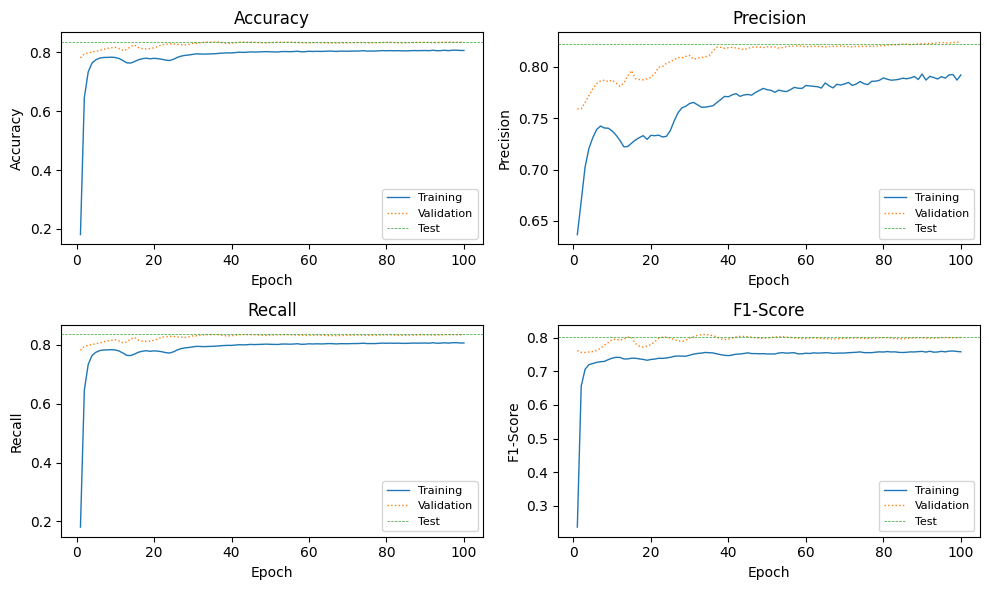

In [315]:
plt.figure(figsize=(10, 6))

# --- Accuracy ----
plt.subplot(2, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, color='C0', linewidth=1.0, label='Training')
plt.plot(range(1, NUM_EPOCHS + 1), val_accuracies, color='C1', linewidth=1.0, label='Validation', linestyle=':')
plt.axhline(y=test_acc, color='C2', linewidth=0.5, linestyle='--', label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(fontsize=8)
plt.title('Accuracy')

# --- Precision ---
plt.subplot(2, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), train_precisions, color='C0', linewidth=1.0, label='Training')
plt.plot(range(1, NUM_EPOCHS + 1), val_precisions, color='C1', linewidth=1.0, label='Validation', linestyle=':')
plt.axhline(y=test_prec, color='C2', linewidth=0.5, linestyle='--', label='Test')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(fontsize=8)
plt.title('Precision')

# --- Recall ---
plt.subplot(2, 2, 3)
plt.plot(range(1, NUM_EPOCHS + 1), train_recalls, color='C0', linewidth=1.0, label='Training')
plt.plot(range(1, NUM_EPOCHS + 1), val_recalls, color='C1', linewidth=1.0, label='Validation', linestyle=':')
plt.axhline(y=test_rec, color='C2', linewidth=0.5, linestyle='--', label='Test')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(fontsize=8)
plt.title('Recall')

# --- F1-Score ---
plt.subplot(2, 2, 4)
plt.plot(range(1, NUM_EPOCHS + 1), train_f1_scores, linewidth=1.0, color='C0', label='Training')
plt.plot(range(1, NUM_EPOCHS + 1), val_f1_scores, linewidth=1.0, color='C1', label='Validation', linestyle=':')
plt.axhline(y=test_f1, color='C2', linewidth=0.5, linestyle='--', label='Test')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend(fontsize=8)
plt.title('F1-Score')

plt.tight_layout()
plt.show()

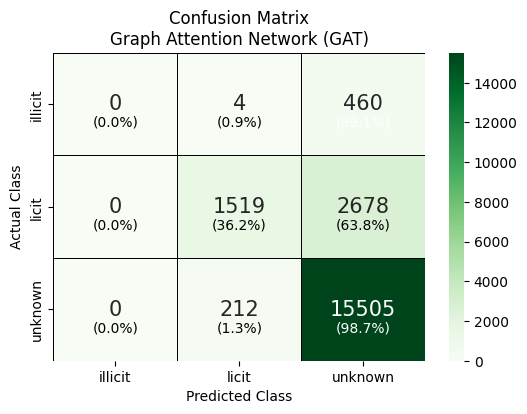

In [304]:
test_pred = predict(model, data)[data.test_mask]

# Map the actual name to the raw class name.
mapping = dict(zip(classes_df['Class Raw'], classes_df['Class Mapped']))
mapped_classes = np.array([mapping[class_value] for class_value in le.classes_])

# --- Confusion matrix ---
cm = confusion_matrix(data.y[data.test_mask].cpu(), test_pred.cpu())

fig, ax = plt.subplots(figsize=(6, 4))

sns.heatmap(cm, annot=True, fmt='g', cmap=plt.cm.Greens, 
            annot_kws={'size': 15}, 
            xticklabels=mapped_classes,
            yticklabels=mapped_classes, 
            linecolor='black', linewidth=0.5,
            ax=ax)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')

# Annotate each cell with the percentage of that row.
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percentage = cm_normalized[i, j] * 100
        text = f'\n({percentage:.1f}%)'
        color = 'white' if percentage > 95 else 'black'
        ax.text(j + 0.5, i + 0.6, text,
                ha='center', va='center', fontsize=10, color=color)

plt.title('Confusion Matrix\nGraph Attention Network (GAT)')
plt.show()

- The model basically mostly predicts a node as being unknown. 
- !!!!!We need to tackle the imbalance!!!!!
- In further iterations I will only train on illicit and licit nodes. 

## 3️⃣ - GIN

# ToDos

- [ ] Outsource the code used for each GNN into global methods. Will make the notebook shorter and more readable.
- [ ] Train only on known nodes. Then validate on a small set of known nodes which was not trained on. Then predict on the unknown.
- [ ] Implement GIN also. 
- [ ] Compare all the models. 
- [ ] Add short explanations for each GNN type + formulas. 
- [ ] Add hyperparameter tuning. 
- [ ] Develop a baseline model (non-GNN). 
- [ ] Perform some graph explanability methods. for example GNNExplainer. 

---


💚 Thank you for reading 💚

If you have any questions or feedback, feel free to leave a comment 🤔

This notebook is __still in progress__.

Please __UPVOTE__ if you enjoyed this notebook 🙏